# PORTAFOLIO DE ANALISIS
# Implementacion de un modelo de Big Data que predice el tipo de moneda Bitcoin
### CARLOS EDUARDO ORTEGA CLEMENT A01707480


In [20]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

In [33]:

from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.executor.memory", "8g").config("spark.driver.memory", "8g").getOrCreate()
spark = SparkSession.builder.appName("Bitcoin").getOrCreate()




23/11/26 20:03:02 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [34]:
# Cargar datos en un DataFrame de Spark
data = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("bitcoin.csv")

#### Primero cargamos los datos y hacemos una limpieza

In [50]:
# Mostrar las primeras 5 filas del DataFrame
data.show(10)


+--------------------+----+---+------+--------------------+-----+------+---------+---------+---------------+
|             address|year|day|length|              weight|count|looped|neighbors|   income|          label|
+--------------------+----+---+------+--------------------+-----+------+---------+---------+---------------+
|111K8kZAEnJg245r2...|2017| 11|    18| 0.00833333333333333|    1|     0|        2|100050000|princetonCerber|
|1123pJv8jzeFQaCV4...|2016|132|    44|      0.000244140625|    1|     0|        1|    1e+08| princetonLocky|
|112536im7hy6wtKbp...|2016|246|     0|                   1|    1|     0|        2|    2e+08|princetonCerber|
|1126eDRw2wqSkWosj...|2016|322|    72|          0.00390625|    1|     0|        2| 71200000|princetonCerber|
|1129TSjKtx65E35Gi...|2016|238|   144|  0.0728484071989931|  456|     0|        1|    2e+08| princetonLocky|
|112AmFATxzhuSpvtz...|2016| 96|   144|  0.0846139993386755| 2821|     0|        1|    5e+07| princetonLocky|
|112E91jxS2qrQY1z7.

In [51]:
# Eliminar filas con valores nulos en cualquier columna
data_cleaned = data.dropna()


In [52]:
# Mostrar los tipos de datos de cada columna
data_cleaned.dtypes


[('address', 'string'),
 ('year', 'string'),
 ('day', 'string'),
 ('length', 'string'),
 ('weight', 'string'),
 ('count', 'string'),
 ('looped', 'string'),
 ('neighbors', 'string'),
 ('income', 'string'),
 ('label', 'string')]

##### observamos que todos los datos son de tipo string por lo que todavia no se pueden hacer visuializaciones de las variables con graficas

Ahora vamos a ver los valores unicos que tiene cada variable para tomar decisiones mas adelante

In [53]:
# Verificar valores únicos en cada columna
for col in data_cleaned.columns:
    unique_values = data_cleaned.select(col).distinct().count()
    print(f"Columna '{col}' tiene {unique_values} valores únicos.")


23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/26 20:08:57 WARN RowBasedKeyValueBatch: Calling spill() on

Columna 'address' tiene 2631095 valores únicos.


Columna 'year' tiene 8 valores únicos.


Columna 'day' tiene 365 valores únicos.


Columna 'length' tiene 73 valores únicos.


Columna 'weight' tiene 785669 valores únicos.


Columna 'count' tiene 11572 valores únicos.


Columna 'looped' tiene 10168 valores únicos.


Columna 'neighbors' tiene 814 valores únicos.


23/11/26 20:09:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Columna 'income' tiene 1866365 valores únicos.


Columna 'label' tiene 29 valores únicos.


In [54]:
# Contar el número total de filas en el DataFrame
total_datos = data_cleaned.count()

# Mostrar el resultado
print("Número total de datos en el DataFrame:", total_datos)


Número total de datos en el DataFrame: 2916697


 A PARTIR DE AQUI, PUEDO DESCARTAR CIERTAS COLUMNAS POR LA CANTIDAD DE VALORES UNICOS QUE SE PRESENTAN, PARA LA PARTE DE ADDRESS CASI TODOS TIENEN UN VALOR UNICO POR LO QUE NO NOS SIRVE EN EL MODELO. PARA LA PARTE DE INCOME TAMBIEN TIENE MUCHOS VALORES UNICOS, SIN EMBARGO NO LOS SUFICIENTES PARA DESCARTAR TODA LA COLUMNA. PROBARE EL MODELO UTILIZANDO ESA COLUMNA Y TAMBIEN SIN USARLA POR SI RESULTA MEJOR.

In [55]:
data_drop = data_cleaned.drop('address')

### Ahora, voy a convertir todas las variables string a numericas para el modelo y su visualizacion, en el caso de los labels igual asignar un valor numerico unico para cada categoria

In [56]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Lista de nombres de columnas numéricas (excluyendo la columna 'label')
columnas_numericas = [col_name for col_name in data_drop.columns if col_name != 'label' and col_name!='weight']


data_drop = data_drop.withColumn("weight", (col("weight") * 1.0).cast("float"))

# Convertir columnas numéricas de tipo string a tipo int
for col_name in columnas_numericas:
   data_drop = data_drop.withColumn(col_name, col(col_name).cast('double').cast('int'))



In [57]:
data_drop.show()

+----+---+------+------------+-----+------+---------+---------+--------------------+
|year|day|length|      weight|count|looped|neighbors|   income|               label|
+----+---+------+------------+-----+------+---------+---------+--------------------+
|2017| 11|    18| 0.008333334|    1|     0|        2|100050000|     princetonCerber|
|2016|132|    44|2.4414062E-4|    1|     0|        1|100000000|      princetonLocky|
|2016|246|     0|         1.0|    1|     0|        2|200000000|     princetonCerber|
|2016|322|    72|  0.00390625|    1|     0|        2| 71200000|     princetonCerber|
|2016|238|   144|  0.07284841|  456|     0|        1|200000000|      princetonLocky|
|2016| 96|   144|    0.084614| 2821|     0|        1| 50000000|      princetonLocky|
|2016|225|   142|0.0020885186|  881|     0|        2|100000000|     princetonCerber|
|2016|324|    78|  0.00390625|    1|     0|        2|100990000|     princetonCerber|
|2016|298|   144|   2.3028283| 4220|     0|        2| 80000000|  

In [58]:

data_drop = data_drop.na.fill(0.0, subset=["weight"])

In [59]:
label_indexer = StringIndexer(inputCol='label', outputCol='label_index')

# Ajustar el modelo y transformar los datos
indexer_model = label_indexer.fit(data_drop)
data_indexed = indexer_model.transform(data_drop)

# Obtener la lista de etiquetas originales
etiquetas_originales = indexer_model.labels

# Mostrar la lista de etiquetas originales y sus índices asignados
print("Etiquetas Originales:", etiquetas_originales)


Etiquetas Originales: ['white', 'paduaCryptoWall', 'montrealCryptoLocker', 'princetonCerber', 'princetonLocky', 'montrealCryptXXX', 'montrealNoobCrypt', 'montrealDMALockerv3', 'montrealDMALocker', 'montrealSamSam', 'montrealCryptoTorLocker2015', 'montrealGlobeImposter', 'montrealGlobev3', 'montrealGlobe', 'montrealWannaCry', 'montrealRazy', 'montrealAPT', 'paduaKeRanger', 'montrealFlyper', 'montrealXTPLocker', 'montrealCryptConsole', 'montrealVenusLocker', 'montrealXLockerv5.0', 'montrealEDA2', 'montrealJigSaw', 'paduaJigsaw', 'montrealComradeCircle', 'montrealSam', 'montrealXLocker']


In [60]:

# Crear un diccionario que mapea etiquetas originales a sus índices asignados
categorias_con_indices = dict(zip(etiquetas_originales, range(len(etiquetas_originales))))

# Mostrar la lista de etiquetas originales y sus índices asignados
#print("Etiquetas Originales:", etiquetas_originales)
print("Categorías con sus respectivos índices asignados:")
print(categorias_con_indices)

Categorías con sus respectivos índices asignados:
{'white': 0, 'paduaCryptoWall': 1, 'montrealCryptoLocker': 2, 'princetonCerber': 3, 'princetonLocky': 4, 'montrealCryptXXX': 5, 'montrealNoobCrypt': 6, 'montrealDMALockerv3': 7, 'montrealDMALocker': 8, 'montrealSamSam': 9, 'montrealCryptoTorLocker2015': 10, 'montrealGlobeImposter': 11, 'montrealGlobev3': 12, 'montrealGlobe': 13, 'montrealWannaCry': 14, 'montrealRazy': 15, 'montrealAPT': 16, 'paduaKeRanger': 17, 'montrealFlyper': 18, 'montrealXTPLocker': 19, 'montrealCryptConsole': 20, 'montrealVenusLocker': 21, 'montrealXLockerv5.0': 22, 'montrealEDA2': 23, 'montrealJigSaw': 24, 'paduaJigsaw': 25, 'montrealComradeCircle': 26, 'montrealSam': 27, 'montrealXLocker': 28}


#### Ahora que todas las variables son numericas, nada mas falta pasar los labels a categorias numericas de igual forma

In [61]:
label_indexer = StringIndexer(inputCol='label', outputCol='label_index')

# Ajustar el modelo y transformar los datos
indexer_model = label_indexer.fit(data_drop)
data_indexed = indexer_model.transform(data_drop)

# Obtener la lista de etiquetas originales
etiquetas_originales = indexer_model.labels

# Mostrar la lista de etiquetas originales y sus índices asignados
print("Etiquetas Originales:", etiquetas_originales)

Etiquetas Originales: ['white', 'paduaCryptoWall', 'montrealCryptoLocker', 'princetonCerber', 'princetonLocky', 'montrealCryptXXX', 'montrealNoobCrypt', 'montrealDMALockerv3', 'montrealDMALocker', 'montrealSamSam', 'montrealCryptoTorLocker2015', 'montrealGlobeImposter', 'montrealGlobev3', 'montrealGlobe', 'montrealWannaCry', 'montrealRazy', 'montrealAPT', 'paduaKeRanger', 'montrealFlyper', 'montrealXTPLocker', 'montrealCryptConsole', 'montrealVenusLocker', 'montrealXLockerv5.0', 'montrealEDA2', 'montrealJigSaw', 'paduaJigsaw', 'montrealComradeCircle', 'montrealSam', 'montrealXLocker']


#### Primero hacemos un show para ver los diferentes valores

In [62]:
data_indexed = data_indexed.drop('label')
data_indexed.show(100)

# Reducir el número de particiones a un valor adecuado
data_indexed = data_indexed.coalesce(4)  # Ajusta el número de particiones según sea necesario


+----+---+------+------------+-----+------+---------+---------+-----------+
|year|day|length|      weight|count|looped|neighbors|   income|label_index|
+----+---+------+------------+-----+------+---------+---------+-----------+
|2017| 11|    18| 0.008333334|    1|     0|        2|100050000|        3.0|
|2016|132|    44|2.4414062E-4|    1|     0|        1|100000000|        4.0|
|2016|246|     0|         1.0|    1|     0|        2|200000000|        3.0|
|2016|322|    72|  0.00390625|    1|     0|        2| 71200000|        3.0|
|2016|238|   144|  0.07284841|  456|     0|        1|200000000|        4.0|
|2016| 96|   144|    0.084614| 2821|     0|        1| 50000000|        4.0|
|2016|225|   142|0.0020885186|  881|     0|        2|100000000|        3.0|
|2016|324|    78|  0.00390625|    1|     0|        2|100990000|        3.0|
|2016|298|   144|   2.3028283| 4220|     0|        2| 80000000|        3.0|
|2016| 62|   112|3.7252903E-9|    1|     0|        1| 50000000|        4.0|
|2013|317|  

## Visualizaciones

#### Ahora procedere a realizar algunas visualizaciones para saber que decisiones tomar


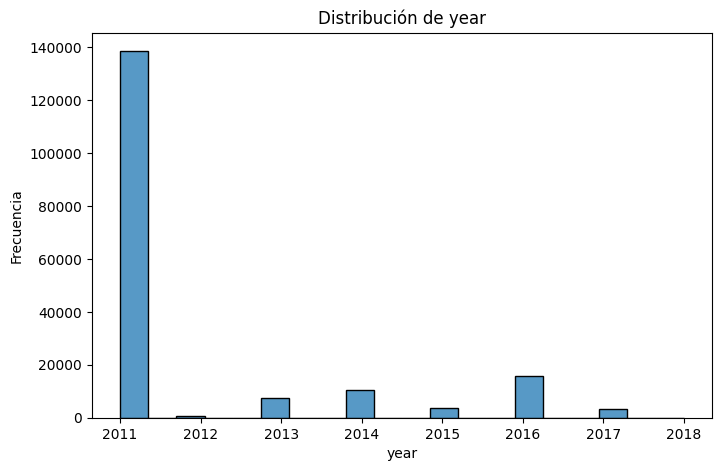

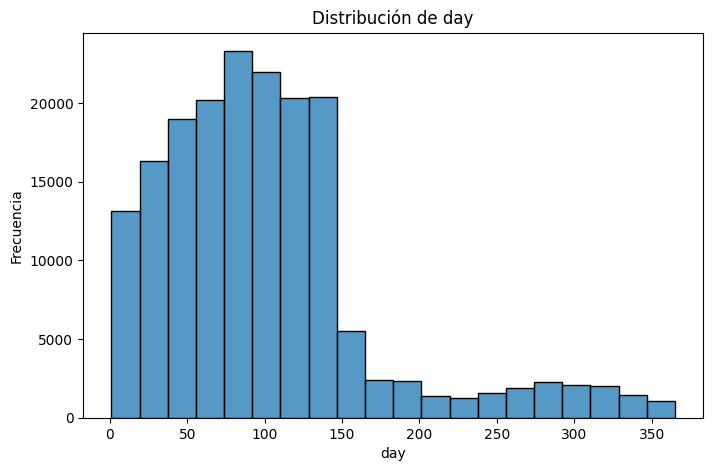

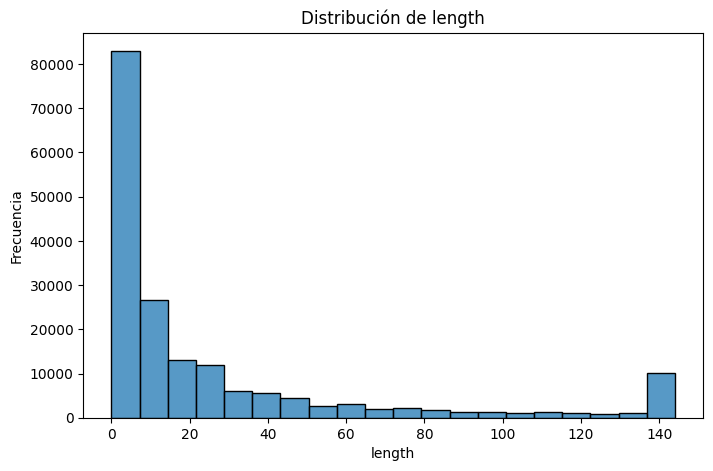

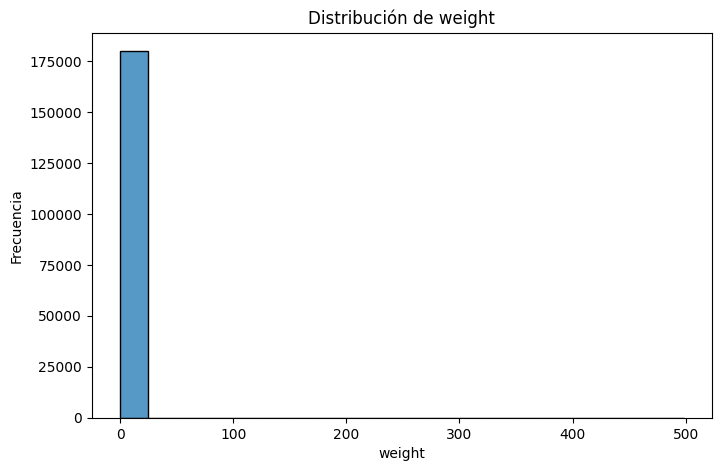

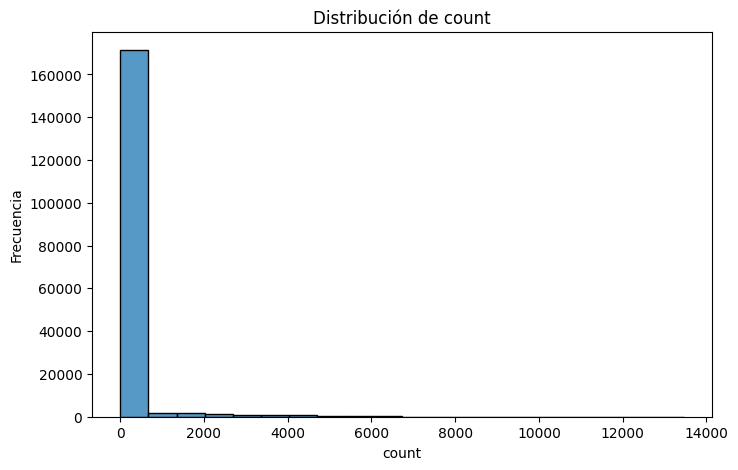

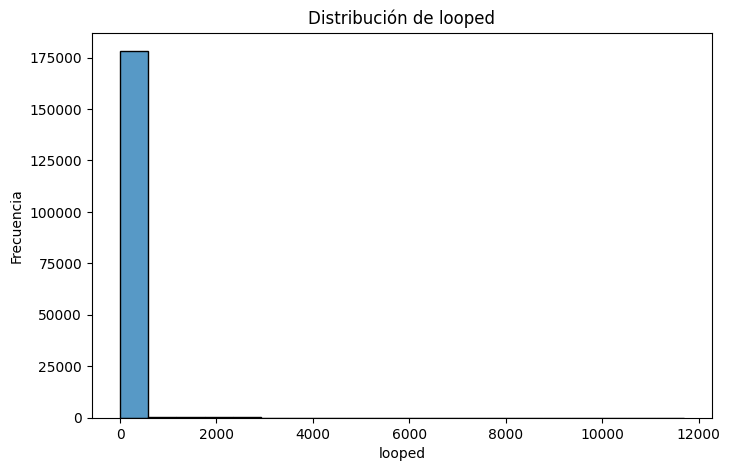

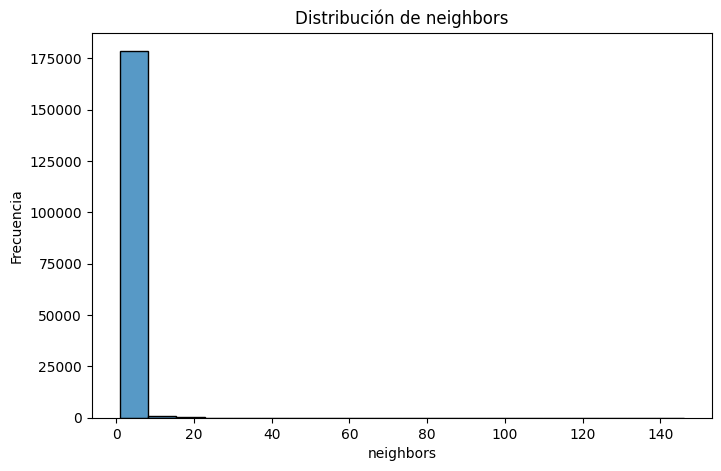

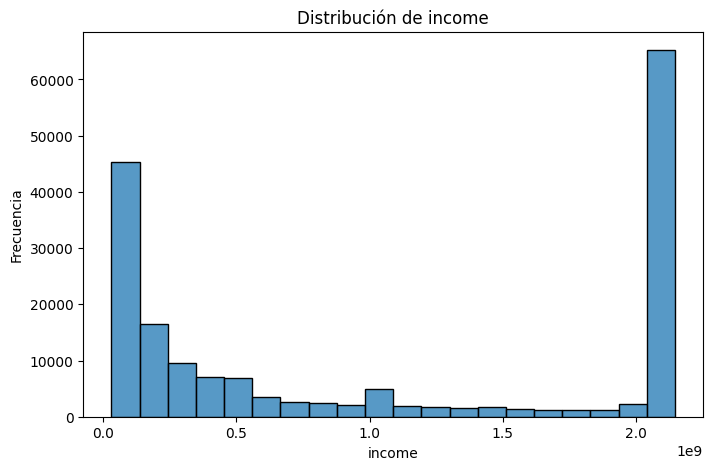

In [75]:
# Convertir a Pandas para visualización
data_pd= data_indexed.limit(180000).toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

columnas_numericas = ['year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']

# Itera sobre cada columna numérica y genera un histograma
for col_name in columnas_numericas:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_pd[col_name], bins=20)
    plt.title(f'Distribución de {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frecuencia')
    plt.show()

En el caso de las distribuciones de nuestras variables, las que se destacan son la variable year es una variable categorica y que casi toda la informacion es del año 2011.  Tambien se puede notar que la varibale weight tiene valores muy pequeños y las variables neighbors y looped pueden ser variables cagtegoricas ya que no cambian. La variable counts tiene posibles outlier que se deben modificar en futuras implementaciones, pero los cuales por el momento no afectan tanto ya que no son tan extremos. Fuera de estas variables no se encuentra un comportamiento o distribucion extraña, por lo que procedere a hacer otro tipo de visualizacion para ver si descarto alguna variable.

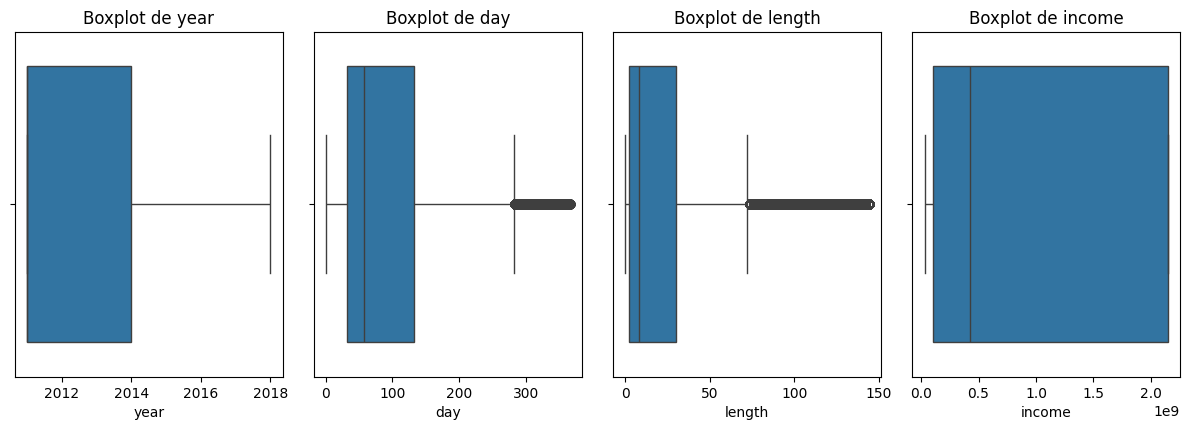

In [112]:

import seaborn as sns
import matplotlib.pyplot as plt

# Convertir a Pandas para visualización
data_pd2= data_indexed.limit(100000).toPandas()

# Especifica las variables que deseas incluir en el boxplot
variables = ['year', 'day', 'length', 'income']

# Crea un boxplot para cada variable
plt.figure(figsize=(12, 8))
for i, variable in enumerate(variables, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=variable, data=data_pd2)
    plt.title(f'Boxplot de {variable}')

plt.tight_layout()
plt.show()


Aqui decidi solo mostrar el boxplot de estas variables ya que las demas se vio que son categoricas o su variacion es minima. De estas variables podemos notar que el income no tiene valores atipicos ya que los bigotes no exceden del 150% del rango intercuartil. Tambien podemos decir que todas las medianas de todas estas variables son asimetricas ya que no se encuentra la linea en el medio de los datos. Pero no es algo que pueda afectar en gran medida nuestro modelo, por lo que podemos mantener estas variables al igual que las anteriormente mencionadas. 

Hare un ultimo grafico que nos puede permitir saber si de todas las variables que no descartamos por distribuciones extrañas o incoherencia en los datos, existen variables que esten estorbando mas que ayudando, o en otras palabras, si tienen multicolinealidad.

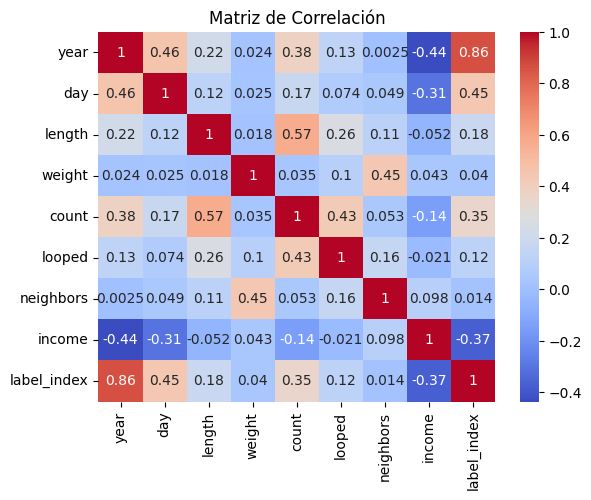

In [76]:
correlation_matrix = data_pd.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

Al hacer un analisis de la correlacion de las variables, podemos notar que no existen variables que tengan una correlacion muy alta entre si, los valores mas altos estan cerca de 0.57 y para que sea multicolinealidad deben estar cercanos a 0.9, eso quiere decir que no existen problemas de multicolinealidad, por lo que podemos mantener todas las variables para entrenar el modelo.

In [77]:
from pyspark.ml.feature import VectorAssembler

# Definir las características de entrada
features = ['year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']

assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_df = assembler.transform(data_indexed)

# Selecciona las columnas "features" y "label" para el modelo
selected_df = assembled_df.select("features", "label_index")

selected_df.show()

+--------------------+-----------+
|            features|label_index|
+--------------------+-----------+
|[2017.0,11.0,18.0...|        3.0|
|[2016.0,132.0,44....|        4.0|
|[2016.0,246.0,0.0...|        3.0|
|[2016.0,322.0,72....|        3.0|
|[2016.0,238.0,144...|        4.0|
|[2016.0,96.0,144....|        4.0|
|[2016.0,225.0,142...|        3.0|
|[2016.0,324.0,78....|        3.0|
|[2016.0,298.0,144...|        3.0|
|[2016.0,62.0,112....|        4.0|
|[2013.0,317.0,4.0...|        2.0|
|[2016.0,247.0,0.0...|        3.0|
|[2016.0,146.0,144...|        5.0|
|[2017.0,3.0,4.0,0...|        3.0|
|[2016.0,158.0,56....|        5.0|
|[2016.0,156.0,8.0...|        5.0|
|[2016.0,273.0,144...|        4.0|
|[2016.0,56.0,4.0,...|        4.0|
|[2016.0,165.0,10....|        3.0|
|[2016.0,109.0,0.0...|        4.0|
+--------------------+-----------+
only showing top 20 rows



Ahora, verificamos los diferentes valores de la columna label con su respectiva etiqueta original para saber de que categoria estamos hablando

In [113]:
train_data, test_data = selected_df.randomSplit([0.8, 0.2], seed=123)


In [79]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Crea el modelo Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label_index", numTrees=200)

# Entrena el modelo
rf_model = rf.fit(train_data)

# Suponiendo que tu modelo se llama "modelo" y que tienes un DataFrame llamado "data_test" para evaluación
predictions = rf_model.transform(test_data)

# Crear un evaluador para problemas de clasificación multiclase
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", metricName="accuracy")
# Calcular la métrica de evaluación (precisión en este caso)
accuracy = evaluator.evaluate(predictions)
print("Accuracy en el conjunto de prueba: ", accuracy)



23/11/26 20:53:13 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
23/11/26 20:53:13 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
23/11/26 20:53:13 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
23/11/26 20:53:14 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
23/11/26 20:53:14 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
23/11/26 20:53:14 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
23/11/26 20:53:14 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
23/11/26 20:53:30 WARN MemoryStore: Not enough space to cache rdd_349_1 in memory! (computed 73.4 MiB so far)
23/11/26 20:53:30 WARN BlockManager: Persisting block rdd_349_1 to disk instead.
23/11/26 20:53:30 WARN MemoryStore: Not enough space to cache rdd_349_0 in memory! (computed 73.4 MiB so far)
23/11/26 20:53:30 WA

Accuracy en el conjunto de prueba:  0.9857002968476627


Podemos observar que el modelo final obtuvo un accuracy del 98%, el cual es un excelente accuracy para implementar el modelo en tiempo real o en una interfaz.